In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_context('poster', font_scale=1.25)

/home/bryan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sns.set_style('ticks')

In [4]:
%load_ext autoreload 

In [5]:
%autoreload 2

In [6]:
import pandas as pd

In [84]:
data = pd.read_excel('./test_data.xlsx')
data.dropna(inplace=True)

In [79]:
times = data.loc[:, 'Time']

In [80]:
def get_elapsed_hours(x):
    """Assumes x is a datetime.time object."""
    time_in_seconds = (60.*60.*x.hour + 60*x.minute + x.second)
    return time_in_seconds/(60.*60.)

In [81]:
elapsed_hours = times.apply(get_elapsed_hours)

Nice. On a logarithmic scale,

In [85]:
good_data = data.A1

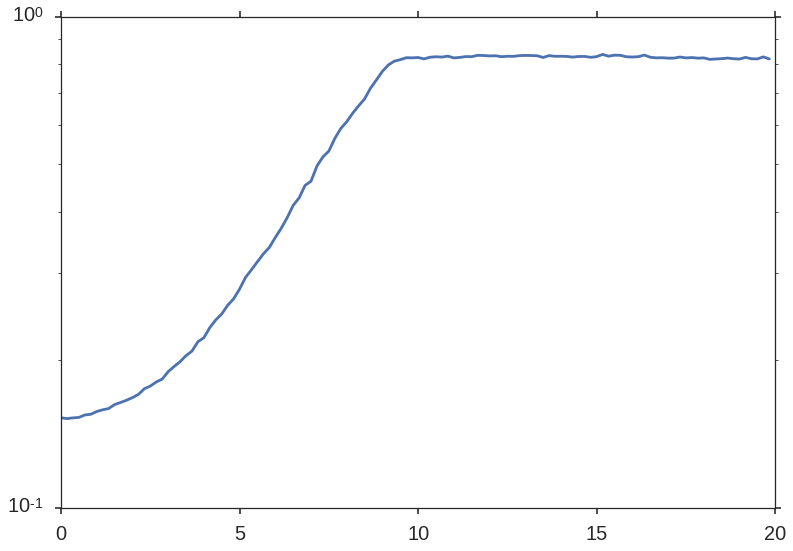

In [87]:
plt.semilogy(elapsed_hours, good_data)

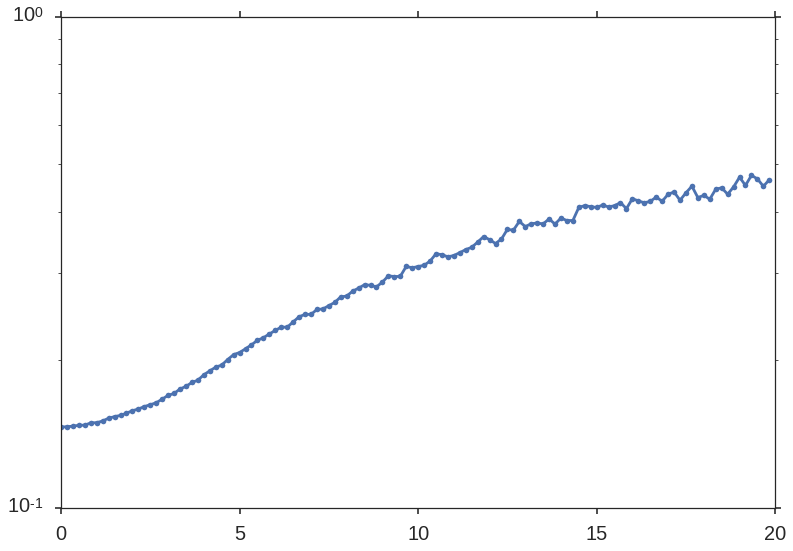

In [89]:
bad_data = data.A10
plt.semilogy(elapsed_hours, bad_data, ls='-', marker='.')

Finding the maximum rate of change is likely a good idea. We can smooth this.

In [92]:
import scipy as sp

In [124]:
data_to_use = np.log(bad_data)
interpolator = sp.interpolate.UnivariateSpline(elapsed_hours, data_to_use, k=5, s=.05)
der = interpolator.derivative()

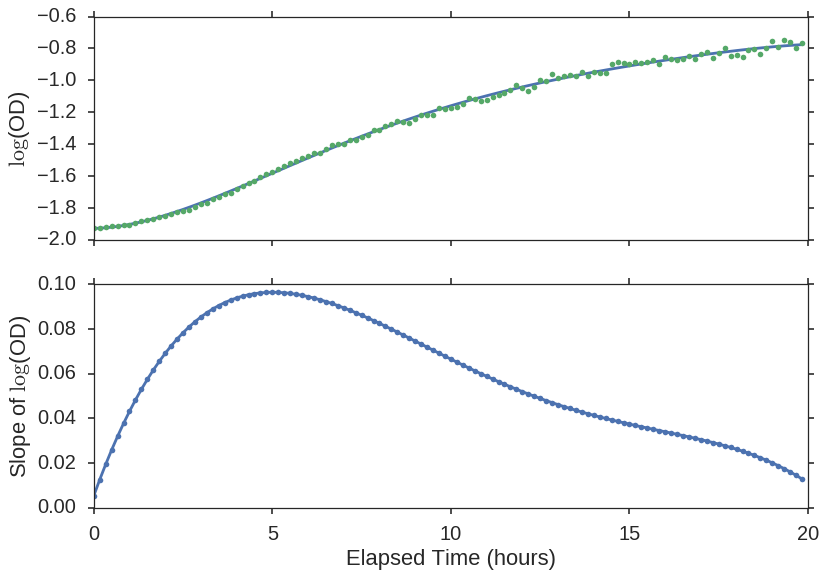

In [125]:
fig, ax = plt.subplots(2, 1, sharex=True)

plt.sca(ax[0])
plt.plot(elapsed_hours, interpolator(elapsed_hours))
plt.plot(elapsed_hours, data_to_use, ls='', marker='.')

plt.ylabel(r'$\log$(OD)')

plt.sca(ax[1])
der = interpolator.derivative()
plt.plot(elapsed_hours, der(elapsed_hours), ls='-', marker='.')

plt.ylabel(r'Slope of $\log$(OD)')

plt.xlabel('Elapsed Time (hours)')

Yes. Good. But you actually have to find the maximum slope. Easy enough.

In [140]:
def get_max_growth_rate(well_str):
    data_to_use = np.log(data.loc[:, well_str]) # Log of the OD
    interpolator = sp.interpolate.UnivariateSpline(elapsed_hours, data_to_use, k=5, s=.05)
    der = interpolator.derivative()
    
    # Get the approximation of the derivative at all points
    der_approx = der(elapsed_hours)
    
    # Get the maximum 
    maximum_index = np.argmax(der_approx)    
    maximum_log_slope = der_approx[maximum_index]
    maximum_time = elapsed_hours.values[maximum_index]
    
    return maximum_log_slope, maximum_time, maximum_index

In [159]:
def plot_growth_prediction(well_str, hours_around_max = 2):
    maximum_log_slope, maximum_time, maximum_index = get_max_growth_rate(well_str)
    
    data_to_use = np.log(data.loc[:, well_str]) # Log of the OD
    
    plt.plot(elapsed_hours, data_to_use, ls='', marker='.', label='Raw Data')
    
    times_around_max = np.linspace(maximum_time - hours_around_max, maximum_time + hours_around_max)
    predicted = times_around_max * maximum_log_slope - maximum_log_slope*maximum_time
    # Add so that predicted is where you expect
    predicted += data_to_use.values[maximum_index]
    
    
    plt.plot(times_around_max, predicted, ls='-', label='Max Growth', color='red', alpha=0.5)
    
    plt.xlabel('Elapsed Time (hours)')
    plt.ylabel(r'$\log$(OD)')
    
    plt.legend(loc='best')
    

In [160]:
get_max_growth_rate('A1')

(0.26936131048763462, 6.166666666666667, 37)

Good. We now loop over all slopes. 